# Environment Setup

In [3]:
# ## 0. Environment Setup & Data Ingestion
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sqlalchemy import create_engine
from metrics_engine import FinancialMetrics
from genetic_engine import GeneticOptimizer

# --- 1. SETUP ---
# Initialize the engine
engine = FinancialMetrics()

print("1. Fetching Full Market History (2006 - Present)...")
# We load everything starting from 2006 to capture the 2008 crash
full_data = engine.load_prices(start_date='2006-01-01')

# Convert index to datetime to avoid errors later
full_data.index = pd.to_datetime(full_data.index)

print("2. Fetching Risk-Free Rate (CETES)...")
# Manual query for CETES since it's in a separate table
cetes_df = pd.read_sql(
    "SELECT date, price AS cetes FROM cetes_data WHERE date >= '2006-01-01'", 
    engine.engine
)
cetes_df.set_index('date', inplace=True)
cetes_df.index = pd.to_datetime(cetes_df.index)

# Merge CETES into the main dataframe
# 'how=left' ensures we keep the stock market calendar
full_data = full_data.join(cetes_df, how='left').ffill()

print(f"Data Ready: {len(full_data.columns)} assets over {len(full_data)} days.")

1. Fetching Full Market History (2006 - Present)...
Fetching data from database...
Loaded prices for 511 assets over 5052 days.
2. Fetching Risk-Free Rate (CETES)...
Data Ready: 512 assets over 5052 days.


# Universe Definition

In [4]:
# ## 1. Data Ingestion & Universe Definition

print("Filtering for 'Veteran' Assets (Survivors of 2008)...")

# 1. Identify Assets with history dating back to pre-2007
CRASH_START = '2007-01-01'
valid_starts = full_data.apply(pd.Series.first_valid_index)
veteran_assets = valid_starts[valid_starts <= CRASH_START].index.tolist()

# 2. Separate Stocks vs. REITs vs. ETFs
meta = pd.read_sql("SELECT ticker, sector FROM assets_metadata", engine.engine)
all_reits = meta[meta['sector'] == 'Real Estate']['ticker'].tolist()

# Exclusion List (ETFs & CETES)
exclude_list = ['VOO', 'VEA', 'VWO', 'VNQ', 'VNQI', 'VGK', 'VPL', 'VT', 'cetes']

# A. Core Equity Veterans (Stocks Only)
core_equity_veterans = [
    t for t in veteran_assets 
    if t not in exclude_list 
    and t not in all_reits
]

# B. REIT Veterans (Real Estate Only)
reit_veterans = [
    t for t in veteran_assets 
    if t in all_reits 
    and t not in exclude_list
]

# Create Clean DataFrames for the AI
df_stocks = full_data[core_equity_veterans].dropna()
df_reits = full_data[reit_veterans].dropna()

print(f"--- Veteran Pools Established ---")
print(f"Equity Veterans: {len(df_stocks.columns)} stocks")
print(f"REIT Veterans:   {len(df_reits.columns)} REITs")

Filtering for 'Veteran' Assets (Survivors of 2008)...
--- Veteran Pools Established ---
Equity Veterans: 373 stocks
REIT Veterans:   29 REITs


# Methodology (Benchmarks)

In [5]:
# ## 2. Methodology: The Passive Benchmark (Swensen Model)

# The "Control Groups"
configs = {
    'Config A (Standard Swensen)': {
        'VOO': 0.30, 'VEA': 0.15, 'VWO': 0.05, 'VNQ': 0.20, 'cetes': 0.30
    },
    'Config B (Global Swensen)': {
        'VOO': 0.30, 'VGK': 0.075, 'VPL': 0.075, 'VWO': 0.05, 'VNQI': 0.20, 'cetes': 0.30
    },
    'Config C (Minimalist)': {
        'VT': 0.70, 'cetes': 0.30
    }
}

# Helper Function: Calculate Metrics
def get_metrics(daily_returns):
    total_return = (daily_returns + 1).prod()
    n_years = len(daily_returns) / 252
    cagr = total_return**(1/n_years) - 1
    vol = daily_returns.std() * np.sqrt(252)
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    
    # Max Drawdown
    cum_returns = (1 + daily_returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_dd = drawdown.min()
    
    return {'CAGR': cagr, 'Vol': vol, 'Sharpe': sharpe, 'Max DD': max_dd}

# --- BENCHMARK DATA LOADER ---
def load_benchmark_data():
    all_tickers = set()
    for conf in configs.values():
        all_tickers.update(conf.keys())
    
    etf_tickers = [t for t in all_tickers if t != 'cetes']

    print('Fetching ETF prices...')
    ticker_str = "', '".join(etf_tickers)
    query = f"SELECT date, ticker, adj_close FROM market_data WHERE ticker IN ('{ticker_str}') AND date >= '2006-01-01'"
    
    df = pd.read_sql(query, engine.engine)
    prices = df.pivot(index='date', columns='ticker', values='adj_close')
    prices.index = pd.to_datetime(prices.index) # Fix Index

    print('Fetching CETES...')
    cetes = pd.read_sql("SELECT date, price as cetes FROM cetes_data WHERE date >= '2006-01-01'", engine.engine)
    cetes.set_index('date', inplace=True)
    cetes.index = pd.to_datetime(cetes.index) # Fix Index

    # Merge
    full_df = prices.join(cetes, how='left').ffill().dropna()
    print(f"Benchmark Data Loaded: {len(full_df)} rows")
    return full_df

# --- EXECUTION ---
baseline_data = load_benchmark_data()
simple_rets = baseline_data.pct_change().dropna()

baseline_results = {}
baseline_curves = {}

# Calculate Portfolio Returns
for name, weights in configs.items():
    port_ret = sum(simple_rets[ticker] * w for ticker, w in weights.items())
    baseline_results[name] = get_metrics(port_ret)
    baseline_curves[name] = 1000 * (1 + port_ret).cumprod()

print("Baseline models calculated.")

Fetching ETF prices...
Fetching CETES...
Benchmark Data Loaded: 3836 rows
Baseline models calculated.


# Benchmark Viz

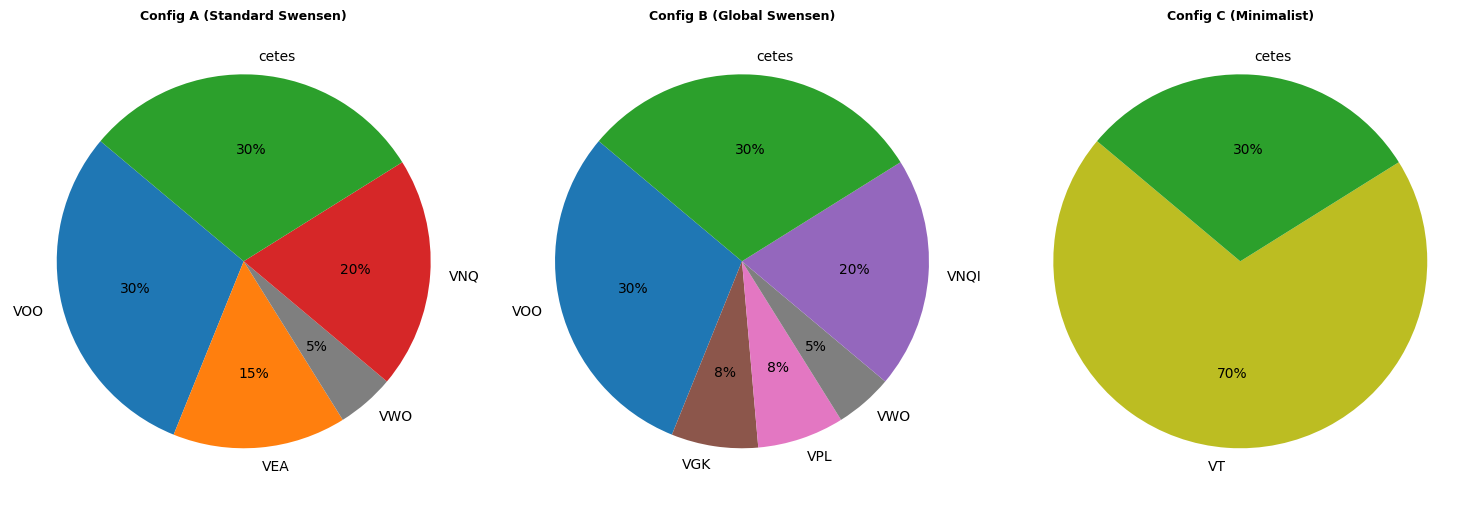

                              CAGR     Vol Sharpe   Max DD
Config A (Standard Swensen)  9.57%  11.70%   0.84  -26.26%
Config B (Global Swensen)    8.73%  11.32%   0.80  -25.05%
Config C (Minimalist)        9.50%  12.00%   0.82  -24.78%


In [6]:
# ## 3. Benchmark Allocations

fig = plt.figure(figsize=(15, 6)) # Shortened height since we removed the line chart
grid = gridspec.GridSpec(1, 3)

colors = {'VOO': '#1f77b4', 'cetes': '#2ca02c', 'VNQ': '#d62728', 
          'VNQI': '#9467bd', 'VEA': '#ff7f0e', 'VGK': '#8c564b', 
          'VPL': '#e377c2', 'VWO': '#7f7f7f', 'VT': '#bcbd22'}

# Pie Charts Only
for i, (name, weights) in enumerate(configs.items()):
    ax = fig.add_subplot(grid[0, i])
    ax.pie(weights.values(), labels=weights.keys(), autopct='%1.0f%%', 
           startangle=140, colors=[colors.get(k, '#333') for k in weights.keys()])
    ax.set_title(name, fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Show Metrics Table
metrics_df = pd.DataFrame(baseline_results).T
metrics_df['CAGR'] = metrics_df['CAGR'].map('{:.2%}'.format)
metrics_df['Vol'] = metrics_df['Vol'].map('{:.2%}'.format)
metrics_df['Sharpe'] = metrics_df['Sharpe'].map('{:.2f}'.format)
metrics_df['Max DD'] = metrics_df['Max DD'].map('{:.2%}'.format)
print(metrics_df)

# Training (In-Sample)

In [7]:
# ## 4. Model Training: In-Sample Optimization (2006-2015)

# The AI knows NOTHING about Trump, COVID, or ChatGPT.
STRICT_SPLIT_DATE = '2016-01-01'

print(f"--- STRICT MODE ENGAGED ---")
print(f"Training Period: 2006-01-01 to {STRICT_SPLIT_DATE}")
print(f"Testing Period:  {STRICT_SPLIT_DATE} to Present")

# 1. Prepare Training Data (Past)
train_stocks = df_stocks[df_stocks.index < STRICT_SPLIT_DATE]
train_reits = df_reits[df_reits.index < STRICT_SPLIT_DATE]

# 2. Train the AI
print("\n>>> Training AI on History...")
ga_stocks = GeneticOptimizer(train_stocks, risk_free_rate=0.04)
strict_best_stocks = ga_stocks.run_optimization(population_size=60, generations=25, portfolio_size=30, seed=927)

ga_reits = GeneticOptimizer(train_reits, risk_free_rate=0.04)
strict_best_reits = ga_reits.run_optimization(population_size=60, generations=25, portfolio_size=10, seed=927)

print(f"\nAI Selected Portfolio (Based on pre-2016 data):")
print(f"Stocks ({len(strict_best_stocks)}): {strict_best_stocks[:5]}...")
print(f"REITs ({len(strict_best_reits)}): {strict_best_reits[:5]}...")

--- STRICT MODE ENGAGED ---
Training Period: 2006-01-01 to 2016-01-01
Testing Period:  2016-01-01 to Present

>>> Training AI on History...
--- Starting Evolution: 25 Gen, 60 Pop, 30 Assets ---
Gen 0: Best Sharpe = 0.3494
Gen 5: Best Sharpe = 0.5102
Gen 10: Best Sharpe = 0.5455
Gen 15: Best Sharpe = 0.5919
Gen 20: Best Sharpe = 0.6428
--- Evolution Complete. Top Sharpe: 0.6758 ---
--- Starting Evolution: 25 Gen, 60 Pop, 10 Assets ---
Gen 0: Best Sharpe = 0.3385
Gen 5: Best Sharpe = 0.4191
Gen 10: Best Sharpe = 0.4191
Gen 15: Best Sharpe = 0.4256
Gen 20: Best Sharpe = 0.4256
--- Evolution Complete. Top Sharpe: 0.4296 ---

AI Selected Portfolio (Based on pre-2016 data):
Stocks (30): ['STZ', 'PNW', 'GL', 'PPL', 'AMZN']...
REITs (10): ['AMT', 'CCI', 'CSGP', 'DLR', 'EQIX']...


# Validation (Out-of-Sample)


>>> Running Out-of-Sample Test (2016 - Present)...


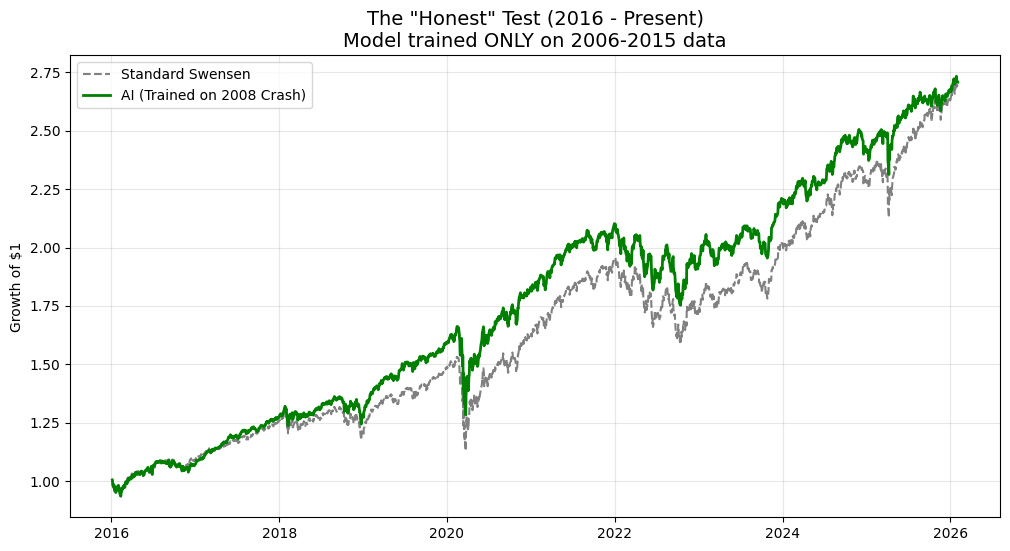

Standard Swensen Return: 169.55%
AI Optimized Return:     170.82%


In [8]:
# ## 5. Thesis Validation: Out-of-Sample Performance (2016-Present)
print(f"\n>>> Running Out-of-Sample Test (2016 - Present)...")

# 1. Slice the "Future" Data
future_data = full_data[full_data.index >= STRICT_SPLIT_DATE].copy()

# 2. Calculate Simple Returns (More accurate than Log for Portfolio Sums)
# We average the daily returns of the components (Equal Weight)
ai_stock_daily = future_data[strict_best_stocks].pct_change().mean(axis=1)
ai_reit_daily = future_data[strict_best_reits].pct_change().mean(axis=1)

# 3. Calculate Benchmark Performance
passive_tickers = ['VOO', 'VNQ', 'VEA', 'VWO', 'cetes']
passive_daily = future_data[passive_tickers].pct_change()

# 4. Construct Portfolios (Daily Weighted Returns)
# Config A: Standard Swensen
std_daily = (
    0.30 * passive_daily['VOO'] + 0.20 * passive_daily['VNQ'] +
    0.15 * passive_daily['VEA'] + 0.05 * passive_daily['VWO'] +
    0.30 * passive_daily['cetes']
).dropna()

# Config X: AI Optimized Swensen
# We swap VOO -> AI Stocks and VNQ -> AI REITs
ai_daily = (
    0.30 * ai_stock_daily + 0.20 * ai_reit_daily +
    0.15 * passive_daily['VEA'] + 0.05 * passive_daily['VWO'] +
    0.30 * passive_daily['cetes']
).dropna()

# 5. Plot
common_idx = std_daily.index.intersection(ai_daily.index)
cum_std = (1 + std_daily[common_idx]).cumprod()
cum_ai = (1 + ai_daily[common_idx]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_std, label='Standard Swensen', color='gray', linestyle='--')
plt.plot(cum_ai, label='AI (Trained on 2008 Crash)', color='green', linewidth=2)

plt.title('The "Honest" Test (2016 - Present)\nModel trained ONLY on 2006-2015 data', fontsize=14)
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Stats
total_std = (cum_std.iloc[-1] - 1) * 100
total_ai = (cum_ai.iloc[-1] - 1) * 100

print(f"Standard Swensen Return: {total_std:.2f}%")
print(f"AI Optimized Return:     {total_ai:.2f}%")